<a href="https://colab.research.google.com/github/ManalSahafi/KhaleejDataset/blob/main/New_Model_SANAD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install utils
!pip install tensorflow --upgrade
!pip install pydot
!pip install graphviz

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.8.0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import time
from collections import Counter

from keras.models import Model
from keras.models import load_model

from keras import layers
from keras import losses
from keras import Sequential
from keras.layers import Dense, Dropout,Activation, MaxPooling1D, Conv1D , Input ,Flatten, Embedding, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf

import matplotlib.pyplot as plt
import pydot
from keras.utils.vis_utils import plot_model

from keras.utils import np_utils

import csv

# **Load Dataset**

In [4]:
path = '/content/drive/MyDrive/Arabic Text Classification/Dataset_without_stemmer.csv'
df = pd.read_csv(path , encoding='UTF-8')
df.rename( columns={'Unnamed: 0':'name'}, inplace=True )
df.drop('name', axis=1, inplace=True)
df.rename( columns={'Normlization':'Text'}, inplace=True )
df.head()

,Label,Text
0,Technology,ابل بدات انتاج نموذج جديد هاتف ايفون نيويورك ف...
1,Technology,ابل تطلق خدمتها لموسيقي بالبث التدفقي نيويورك ...
2,Technology,ابل تعتزم منافسه غوغل سوق مشغلات الاتصالات دبي...
3,Technology,ابل سيري تحدث العربيه لاول سان فرانسيسكو رويتر...
4,Technology,امازون تطلق تطبيقا لخدمه التخزين السحابي دبي ا...


In [ ]:
def PreProcess_Label(label):
  if label == 'Technology':
    return 0
  elif label == 'Sports':
    return 1
  elif label == 'Religion':
    return 2
  elif label == 'Medical':
    return 3

In [ ]:
df["procssLabel"] = df["Label"].apply(lambda x: PreProcess_Label(x))
df.head()

,Label,Text,procssLabel
0,Technology,ابل بدات انتاج نموذج جديد هاتف ايفون نيويورك ف...,0
1,Technology,ابل تطلق خدمتها لموسيقي بالبث التدفقي نيويورك ...,0
2,Technology,ابل تعتزم منافسه غوغل سوق مشغلات الاتصالات دبي...,0
3,Technology,ابل سيري تحدث العربيه لاول سان فرانسيسكو رويتر...,0
4,Technology,امازون تطلق تطبيقا لخدمه التخزين السحابي دبي ا...,0


In [ ]:
df = df[['procssLabel','Text']]
X = df['Text'].fillna('').tolist()
X = [str(i) for i in X]
y = df['procssLabel'].fillna('').tolist()
print(df['procssLabel'].value_counts())

0    10000
1    10000
2    10000
3    10000
Name: procssLabel, dtype: int64


In [ ]:
RANDOM_SEED=42
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8,random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.8, random_state=RANDOM_SEED)

print('Train data len: \n'+str(len(X_train)))
print('Class distribution for Train Data: \n'+str(Counter(y_train)))
print('-------------------------------------')
print('Valid data len: \n'+str(len(X_valid)))
print('Class distribution for Vaild Data: \n'+ str(Counter(y_valid)))
print('-------------------------------------')
print('Test data len: \n'+str(len(X_test)))
print('Class distribution for Test Data: \n'+ str(Counter(y_test)))


Train data len: 
32000
Class distribution for Train Data: 
Counter({1: 8033, 2: 8014, 3: 8000, 0: 7953})
-------------------------------------
Valid data len: 
1600
Class distribution for Vaild Data: 
Counter({0: 405, 3: 401, 2: 399, 1: 395})
-------------------------------------
Test data len: 
6400
Class distribution for Test Data: 
Counter({0: 1642, 3: 1599, 2: 1587, 1: 1572})


In [ ]:
test = pd.concat([X_test, y_test])
test.to_csv('test_dataset.csv')

## **Tokeniztion**

In [ ]:
num_words = 100000
tokenizer = Tokenizer(num_words=num_words, oov_token="unk")
tokenizer.fit_on_texts(X_train)

print("Vocabulary size = {}".format(len(tokenizer.word_index)))
print("Number of Documents = {}".format(tokenizer.document_count))

Vocabulary size = 352325
Number of Documents = 32000


### **Sequnences**

In [ ]:
x_train = tokenizer.texts_to_sequences(X_train) 
x_valid = tokenizer.texts_to_sequences(X_valid) 
x_test  = tokenizer.texts_to_sequences(X_test)
#print(x_train[0])


## **Padding**

In [ ]:
# longest text in train set
max_size = max(len(x) for x in X_train) 
print('The longest text in train set: \n', max_size)

x_train = pad_sequences(x_train, padding = "pre", maxlen = max_size)
x_valid = pad_sequences(x_valid, padding = "pre", maxlen = max_size)
x_test =  pad_sequences(x_test,   padding = "pre", maxlen = max_size)
x_train.shape,x_test.shape

#print('example \n', x_train[0])


The longest text in train set: 
 16666


((32000, 16666), (6400, 16666))

## **Label Encoding** (one-hot-encding)

In [ ]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = tf.keras.utils.to_categorical(train_labels,4)
print("train_labels \n", train_labels)

valid_labels = le.transform(y_valid)
valid_labels = tf.keras.utils.to_categorical(valid_labels,4)
print("valid_labels \n", valid_labels)

test_labels = le.transform(y_test)
test_labels = tf.keras.utils.to_categorical(test_labels,4)
print("test_labels \n", test_labels)
list(le.classes_)

train_labels 
 [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
valid_labels 
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
test_labels 
 [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


[0, 1, 2, 3]

In [ ]:
#to create tensore Dataset from our Dataset
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds  = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

## **CNN** **Architecture**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16666, 64)         19484480  
                                                                 
 conv1d_2 (Conv1D)           (None, 16664, 128)        24704     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 19,509,700
Trainable params: 19,509,700
Non-trainable params: 0
__________________________________________

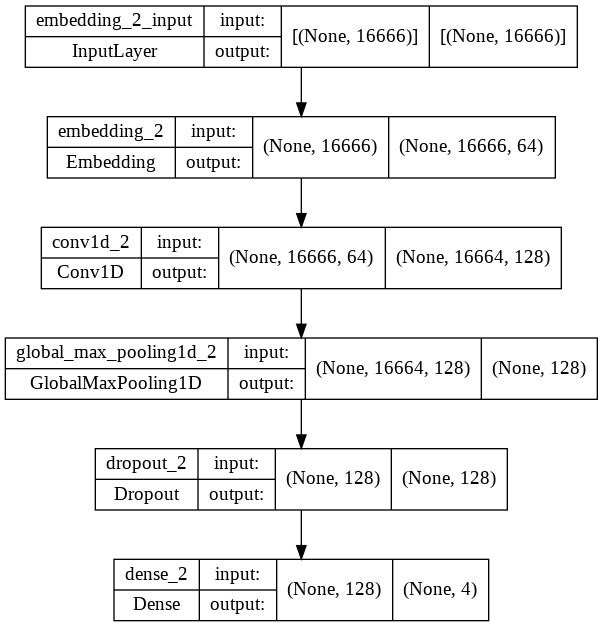

In [ ]:
embedding_dim = 64
max_length = 16666
vocab_size = 304445
# initilaizing the Sequential nature for CNN model
model = Sequential() 
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=["CategoricalAccuracy"])

tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
epochs = 10 
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=2)

Epoch 1/10
250/250 - 67s - loss: 0.4293 - categorical_accuracy: 0.8847 - val_loss: 0.1228 - val_categorical_accuracy: 0.9606 - 67s/epoch - 269ms/step
Epoch 2/10
250/250 - 67s - loss: 0.1038 - categorical_accuracy: 0.9701 - val_loss: 0.0793 - val_categorical_accuracy: 0.9744 - 67s/epoch - 268ms/step
Epoch 3/10
250/250 - 66s - loss: 0.0706 - categorical_accuracy: 0.9795 - val_loss: 0.0696 - val_categorical_accuracy: 0.9775 - 66s/epoch - 264ms/step
Epoch 4/10
250/250 - 65s - loss: 0.0544 - categorical_accuracy: 0.9843 - val_loss: 0.0681 - val_categorical_accuracy: 0.9794 - 65s/epoch - 261ms/step
Epoch 5/10
250/250 - 66s - loss: 0.0445 - categorical_accuracy: 0.9871 - val_loss: 0.0671 - val_categorical_accuracy: 0.9800 - 66s/epoch - 263ms/step
Epoch 6/10
250/250 - 66s - loss: 0.0370 - categorical_accuracy: 0.9900 - val_loss: 0.0641 - val_categorical_accuracy: 0.9800 - 66s/epoch - 263ms/step
Epoch 7/10
250/250 - 66s - loss: 0.0286 - categorical_accuracy: 0.9923 - val_loss: 0.0679 - val_cate

In [ ]:
test_loss, test_acc = model.evaluate(x_test, test_labels, verbose=2)

200/200 - 6s - loss: 0.0734 - categorical_accuracy: 0.9817 - 6s/epoch - 30ms/step


### **Visualize accuracy**

In [ ]:
history.history

In [ ]:
!pip install plot_keras_history

(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f826e0a0d50>,
       dtype=object))

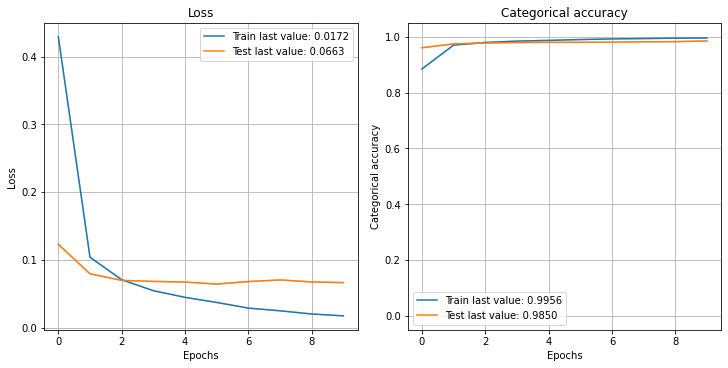

In [ ]:
from plot_keras_history import show_history, plot_history
plot_history(history)

In [ ]:
predict_x=model.predict(x_test)
print(predict_x)
classes_x=np.argmax(predict_x,axis=1)
print('Prediction: ',classes_x)

[[1.6257686e-04 9.9812001e-01 1.7138745e-03 3.5366145e-06]
 [4.6821546e-15 5.1246821e-13 1.0000000e+00 5.0940795e-14]
 [9.9996531e-01 1.5374329e-08 1.0517510e-06 3.3633398e-05]
 ...
 [1.5851230e-09 1.0000000e+00 6.2581731e-09 7.0819156e-11]
 [2.1529208e-01 2.8428272e-04 1.1048207e-02 7.7337545e-01]
 [2.6403404e-10 1.0000000e+00 9.9521369e-10 2.0228742e-11]]
Prediction:  [1 2 0 ... 1 3 1]


In [ ]:
data=pd.DataFrame()
data['pred'] = classes_x
#data.to_csv('test_pred.csv')

## **Predict script**

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1642
           1       0.99      0.99      0.99      1572
           2       0.98      0.99      0.98      1587
           3       0.98      0.98      0.98      1599

    accuracy                           0.98      6400
   macro avg       0.98      0.98      0.98      6400
weighted avg       0.98      0.98      0.98      6400



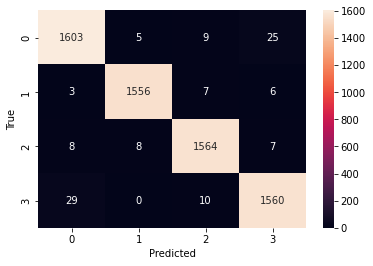

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

#test=pd.read_csv('/content/test_pred.csv')
test_true= pd.read_excel('/content/true_test.xlsx')
    
print(classification_report(test_true['label'], data['pred']))

cm = confusion_matrix(test_true['label'], data['pred'])
df_cm = pd.DataFrame(cm)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
plt.ylabel('True')
plt.xlabel('Predicted');

## **Save/Load model**

In [ ]:
model.save('/content/drive/MyDrive/Arabic Text Classification/SANAD_model.h5')
model_load = load_model('/content/drive/MyDrive/Arabic Text Classification/SANAD_model.h5')
model_load.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16666, 64)         19484480  
                                                                 
 conv1d_2 (Conv1D)           (None, 16664, 128)        24704     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 19,509,700
Trainable params: 19,509,700
Non-trainable params: 0
__________________________________________